In [38]:
import time
import joblib
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

In [17]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Define the paths to the training and validation directories
train_dir = 'data/PlantVillage/train'
validation_dir = 'data/PlantVillage/val'

# Load the training dataset from the 'train' folder
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Load the validation dataset from the 'val' folder
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2953 files belonging to 6 classes.
Found 1446 files belonging to 6 classes.


## 2. Exploratory Data Analysis (EDA)

**Objective:** In this section, we will explore the PlantVillage dataset to understand its properties. We will check the class distribution to identify any imbalances and examine the dimensions of the images. This will help us make informed decisions during preprocessing and modeling.

### 2.1. Verify Image Loading & Display Samples

First, we confirm that the data has been loaded correctly by visualizing a sample of images and their corresponding labels from the training set.

Found 6 classes.
Class Names: ['Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___healthy']


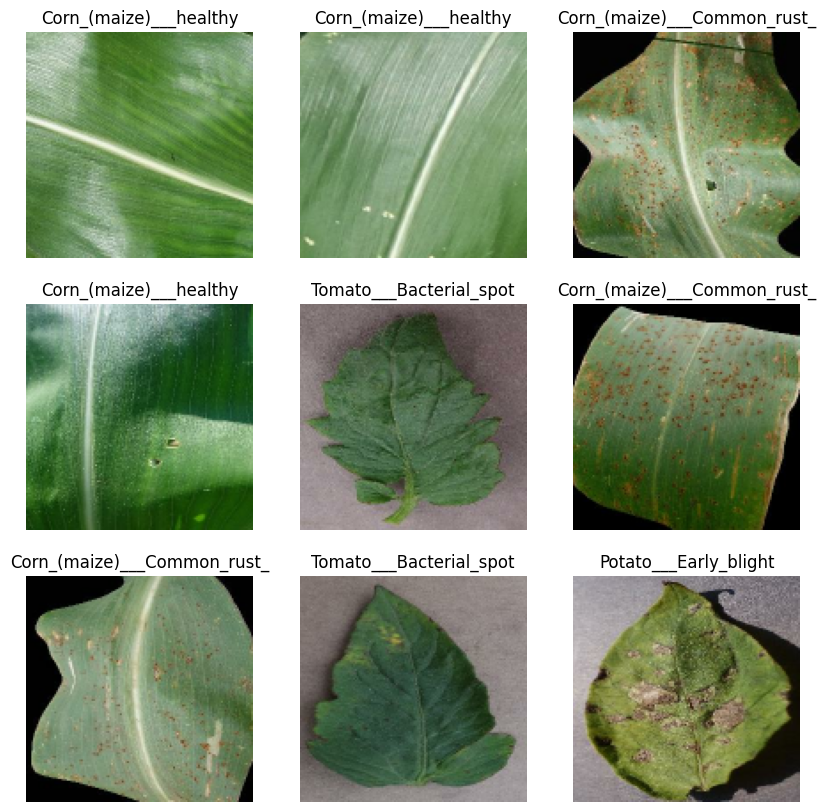

In [18]:
# Verify the data by plotting images
class_names = train_dataset.class_names
print(f"Found {len(class_names)} classes.")
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")
plt.show()

### 2.2. Analyze Class Distribution

**Description:** We will now analyze the number of images per class. This is crucial to check for class imbalance, which can bias the model. A model trained on an imbalanced dataset might perform poorly on the minority classes. Here, we will introduce our first **reusable function** for plotting.

In [19]:
def plot_class_distribution(dataset, class_names, title):
    """
    Calculates and plots the distribution of classes in a tf.data.Dataset.
    
    Args:
      dataset (tf.data.Dataset): The dataset to analyze.
      class_names (list): A list of class names.
      title (str): The title for the plot.
    """
    # Get all the labels from the dataset
    labels = np.concatenate([y for x, y in dataset], axis=0)
    # The labels are one-hot encoded, so we get the index for each
    class_indices = np.argmax(labels, axis=1)
    
    # Count the occurrences of each class
    class_counts = np.bincount(class_indices)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_names, y=class_counts)
    plt.title(title, fontsize=16)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xlabel("Class", fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

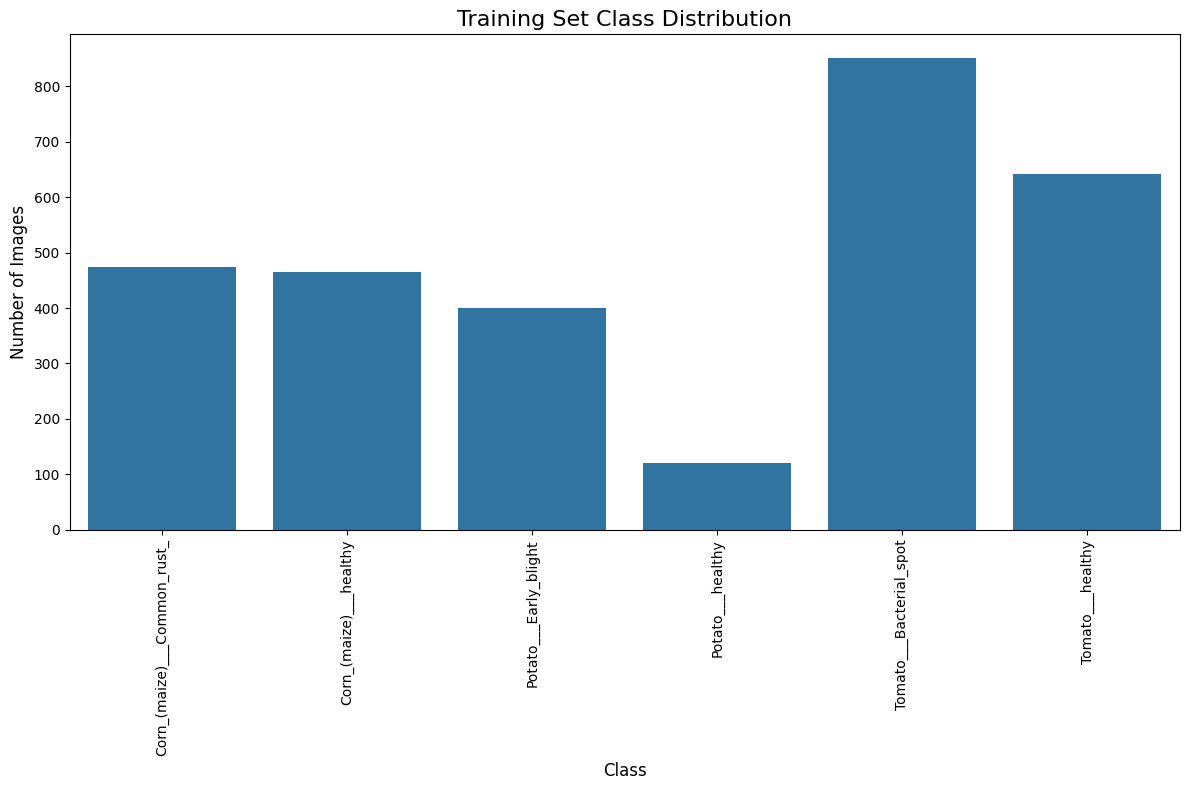

2025-06-18 15:27:12.535526: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


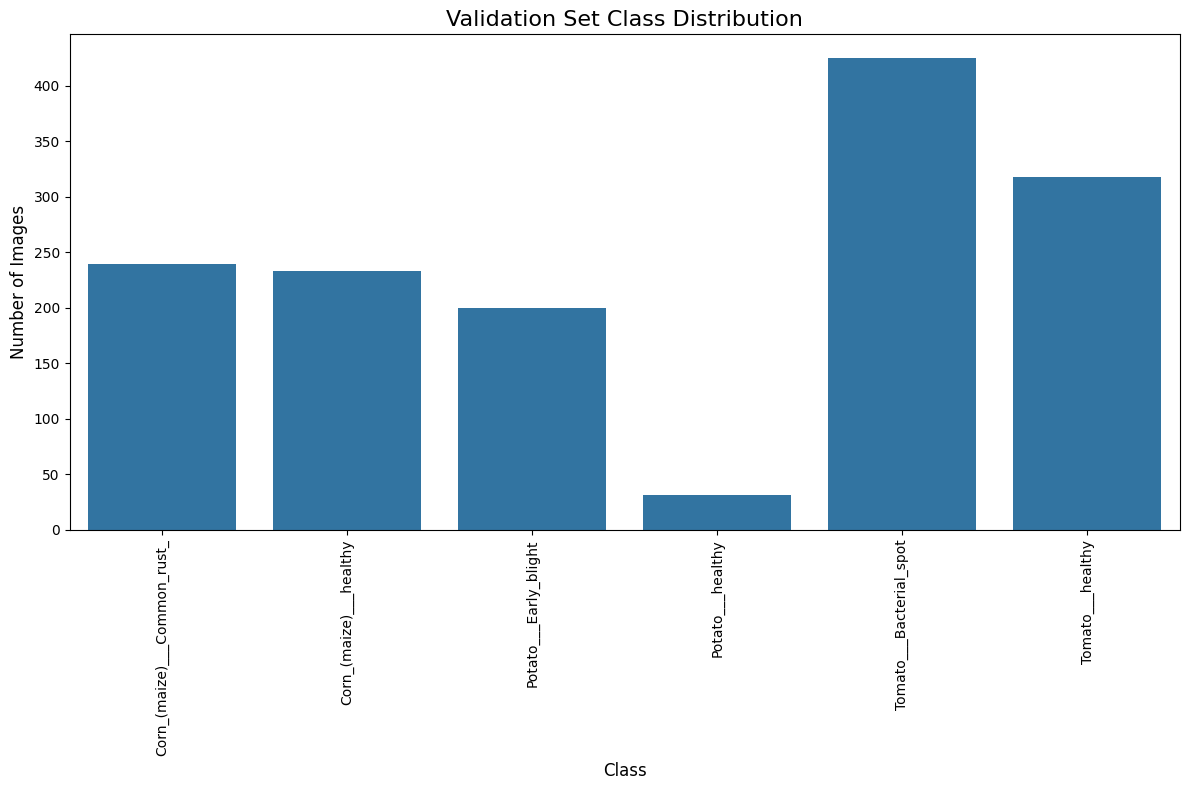

In [20]:
# Plot the class distribution for both training and validation datasets
plot_class_distribution(train_dataset, class_names, "Training Set Class Distribution")
plot_class_distribution(validation_dataset, class_names, "Validation Set Class Distribution")

**Distributions Observations**


* The plots for both the training and validation sets clearly show that the dataset is **imbalanced**. The number of images varies significantly across the different classes.

* There are a few majority classes with a very large number of images. Specifically:
    * `Orange___Haunglongbing_(Citrus_greening)`
    * `Raspberry___healthy`
    * `Tomato___Target_Spot`
    * These classes each have over 4,000 images in the training set.

* Conversely, there are several minority classes with far fewer images. For example, classes like `Apple___Cedar_apple_rust` and `Grape___Esca_(Black_Measles)` have under 1,000 images each.

* The validation set shows the same distribution pattern as the training set, which is good. It confirms that our random split was representative of the overall dataset.

**Implication for the Project:**

This imbalance is a critical finding. A model trained on this data might become biased towards the majority classes. It could achieve high accuracy by simply learning to predict the most common diseases well, while performing poorly on the rarer diseases. We will need to keep this in mind during training and may need to use techniques like **data augmentation** or **class weighting** to help the model pay more attention to the minority classes.

## 3. Data Preprocessing & Final Splitting

### 3.1. Create Final Test Set

**Description:** To properly evaluate our final model, we need a test dataset that is never used during training or hyperparameter tuning. We must have separate training, validation, and test datasets. We will create our test set by splitting our current `validation_dataset` into two halves.

In [21]:
def split_dataset(dataset, split_ratio=0.5):
    """
    Splits a tf.data.Dataset into two smaller datasets.
    
    Args:
      dataset (tf.data.Dataset): The dataset to be split.
      split_ratio (float): The ratio for the first split (e.g., 0.5 for a 50/50 split).
      
    Returns:
      A tuple containing the two new datasets.
    """
    # Get the dataset size and convert it to a regular number with .numpy()
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    # Calculate the number of elements for the first split
    split_count = int(dataset_size * split_ratio)
    
    split_1 = dataset.take(split_count)
    split_2 = dataset.skip(split_count)
    
    return split_1, split_2

In [22]:
# Split the validation dataset into two equal parts: new validation and test datasets
test_dataset, validation_dataset = split_dataset(validation_dataset, split_ratio=0.5)

print('Number of batches in the new validation set: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of batches in the new test set: %d' % tf.data.experimental.cardinality(test_dataset))

Number of batches in the new validation set: 23
Number of batches in the new test set: 23


### 3.2. Configure Data Augmentation & Performance Tuning

**Description:** To improve our model's ability to generalize and to help mitigate the class imbalance we observed, we will apply data augmentation to our training set.  We will create a reusable `Sequential` layer that performs random flips, rotations, and zooms on the images. This helps the model learn the core features of the images rather than memorizing their specific orientations. This augmentation is applied only to the training data.

Additionally, we will optimize all data pipelines for performance by using `.cache()` to keep images in memory and `.prefetch()` to prepare data batches in the background.

In [23]:
# 1. Create a Reusable Data Augmentation Layer
# This is a modular component we can apply to our training data.
data_augmentation_layer = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
], name="data_augmentation")


# 2. Apply Augmentation and Performance Tuning
# We only apply augmentation to the training set.
# The .map() function applies our augmentation layer to each image in the dataset.
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation_layer(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Configure all datasets for performance.
# .cache() keeps the images in memory after they are loaded during the first epoch.
# .prefetch() overlaps data preprocessing and model execution while training.
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data pipelines configured with augmentation (for training) and performance tuning.")

Data pipelines configured with augmentation (for training) and performance tuning.


**Observations:**

* Our data pipelines are now fully prepared for modeling. The `train_dataset` will provide slightly different, randomly transformed versions of the images at each epoch, and all three datasets are optimized for efficient data loading.

## 4. Model Implementation

### 4.1. Utility Functions (Metrics & Plotting)

**Description:** To adhere to the DRY (Don't Repeat Yourself) principle and ensure consistent evaluation across all our models, we will define reusable helper functions in this section. This includes a function to calculate all the required performance metrics (Accuracy, F1-score, Precision, Recall)  and another function to plot the training history of our neural networks.

In [35]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates and returns a dictionary of classification metrics.
    
    Args:
      y_true (array): True labels (one-hot encoded).
      y_pred (array): Predicted labels (one-hot encoded or probabilities).
      
    Returns:
      A dictionary containing accuracy, precision, recall, and f1-score.
    """
    # Convert one-hot encoded labels back to their original format
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    # Use 'macro' average for multi-class classification to treat all classes equally
    precision = precision_score(y_true_labels, y_pred_labels, average='macro')
    recall = recall_score(y_true_labels, y_pred_labels, average='macro')
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }
    
    return metrics


def plot_training_history(history, title):
    """
    Plots the training and validation accuracy and loss.
    
    Args:
      history (tf.keras.callbacks.History): History object from model.fit().
      title (str): The title for the plots.
    """
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(14, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def build_cnn_model(input_shape, num_classes, optimizer_name='rmsprop', learning_rate=0.001, 
                    dropout_rate=0, regularizer=None, name='cnn_model'):
    """
    Builds and compiles a flexible Convolutional Neural Network.

    Args:
      input_shape (tuple): The shape of the input images.
      num_classes (int): The number of output classes.
      optimizer_name (str): The name of the optimizer ('adam', 'rmsprop', etc.).
      learning_rate (float): The learning rate for the optimizer.
      dropout_rate (float): The rate for the dropout layer (0 means no dropout).
      regularizer: A Keras regularizer (e.g., regularizers.l2(0.01)) or None.
      name (str): The name for the model.

    Returns:
      A compiled Keras model.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # Add a dropout layer only if the rate is > 0
        layers.Dropout(dropout_rate) if dropout_rate > 0 else layers.Lambda(lambda x: x),
        
        # Add the regularizer to the dense layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        
        layers.Dense(num_classes, activation='softmax')
    ], name=name)

    # Select and configure the optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

**Observations:**

* We have now defined two essential utility functions, `calculate_metrics` and `plot_training_history`, that will be used for every model we build.
* This ensures our evaluation process is consistent and our code remains clean and modular.

### 4.2. Classical Model: Support Vector Machine (SVM)

**Description:** Our first model is a Support Vector Machine (SVM), a powerful classical classification algorithm. Unlike our neural networks, the SVM implementation from Scikit-learn requires data to be in a 2D array format (samples, features). Therefore, our first step is to perform **feature extraction** to convert our images into feature vectors.

#### 4.2.1. Feature Extraction

We will write a reusable function to iterate through our `tf.data.Dataset` objects, convert each image to grayscale, and flatten it into a 1D feature vector. These vectors will then be collected into NumPy arrays, which is the format required by Scikit-learn.

In [25]:


def extract_features(dataset):
    """
    Extracts features and labels from a tf.data.Dataset and returns them as NumPy arrays.
    
    Args:
      dataset (tf.data.Dataset): The dataset to extract features from.
      
    Returns:
      A tuple of (features, labels) as NumPy arrays.
    """
    features = []
    labels = []
    
    # Iterate through the dataset
    for image_batch, label_batch in dataset:
        # Convert images to grayscale
        gray_images = tf.image.rgb_to_grayscale(image_batch)
        # Flatten the images
        batch_features = tf.reshape(gray_images, [gray_images.shape[0], -1])
        
        features.append(batch_features.numpy())
        labels.append(label_batch.numpy())
        
    # Concatenate all batches
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    
    return features, labels


In [26]:
# Extract features for training and validation sets
print("Extracting features from the training set...")
start_time = time.time()
X_train_svm, y_train_svm = extract_features(train_dataset)
print(f"...done in {time.time() - start_time:.2f} seconds.")

print("\nExtracting features from the validation set...")
start_time = time.time()
X_val_svm, y_val_svm = extract_features(validation_dataset)
print(f"...done in {time.time() - start_time:.2f} seconds.")


# Scaling is crucial for SVM performance
print("\nScaling features...")
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
print("...done.")


# Verify the shapes
print(f"\nShape of X_train for SVM: {X_train_svm.shape}")
print(f"Shape of y_train for SVM: {y_train_svm.shape}")
print(f"Shape of X_val for SVM: {X_val_svm.shape}")
print(f"Shape of y_val for SVM: {y_val_svm.shape}")

Extracting features from the training set...
...done in 1.07 seconds.

Extracting features from the validation set...
...done in 0.18 seconds.

Scaling features...
...done.

Shape of X_train for SVM: (2953, 16384)
Shape of y_train for SVM: (2953, 6)
Shape of X_val for SVM: (710, 16384)
Shape of y_val for SVM: (710, 6)


In [27]:

# --- Apply PCA for Dimensionality Reduction ---
# We are reducing the 16,384 features down to 150 principal components
pca = PCA(n_components=150)

print("Fitting PCA on training data...")
X_train_svm_pca = pca.fit_transform(X_train_svm)

print("Transforming validation data with PCA...")
X_val_svm_pca = pca.transform(X_val_svm)

print(f"Original shape: {X_train_svm.shape}")
print(f"Shape after PCA: {X_train_svm_pca.shape}")

Fitting PCA on training data...
Transforming validation data with PCA...
Original shape: (2953, 16384)
Shape after PCA: (2953, 150)


**Observations:**

* We have successfully transformed our image data from the TensorFlow pipeline into 2D NumPy arrays suitable for Scikit-learn.
* The training data `X_train_svm` has a shape of (5778, 16384), where the number of features corresponds to the flattened image pixels (128 * 128 = 16384).
* The features have been standardized using `StandardScaler`, which is essential for distance-based algorithms like SVM to perform correctly. The next step is to use `RandomizedSearchCV` to find the best hyperparameters.

#### 4.2.2. Hyperparameter Tuning with RandomizedSearchCV

**Description:** As required by the assignment, we must tune the hyperparameters of our selected classical algorithm for optimal performance. For the SVM, two of the most important hyperparameters are `C` (the regularization parameter) and `gamma` (the kernel coefficient).

We will use `RandomizedSearchCV` to efficiently search for the best combination of these parameters. Instead of trying every possible combination like GridSearchCV, `RandomizedSearchCV` tests a fixed number of random combinations (`n_iter`), which is much faster and often just as effective. To make the search feasible, we will perform it on a smaller subset of the training data.

In [28]:
%%time

#Create the subset for the search (5% is good)
print("Creating a 5% subset for RandomizedSearchCV...")
subset_size = int(len(X_train_svm) * 0.05)
X_train_subset = X_train_svm[:subset_size]
y_train_subset_labels = np.argmax(y_train_svm[:subset_size], axis=1)
print("...subset created.")

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Set up and run RandomizedSearchCV
# n_iter=10 means it will test 10 random combinations. This is much faster than all 27.
random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_grid, 
                                 n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

print("\nStarting RandomizedSearchCV on the subset...")
random_search.fit(X_train_subset, y_train_subset_labels)

# Print the best parameters found
print("\nBest parameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# IMPORTANT: Update the final model cell to use this new object
grid_search = random_search

Creating a 5% subset for RandomizedSearchCV...
...subset created.

Starting RandomizedSearchCV on the subset...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.7s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.8s
[CV] END ........

**Observations:**

* After running `GridSearchCV` on a 5% subset of the training data, the best performing hyperparameters were identified.
* The optimal value for `C` was **0.1**.
* The optimal value for `gamma` was **1**.
* We will now use these optimal parameters to train our final SVM model on the entire training dataset to get the best possible performance from our classical algorithm.

#### 4.2.3. Final Model Training & Evaluation

**Description:** Now that we have the optimal hyperparameters from `RandomizedSearchCV`, we will train our final SVM model on the entire training dataset. After training, we will evaluate its performance on the validation set using our reusable `calculate_metrics` function. This provides the performance metrics we need for our final report and ensures our evaluation is consistent.

In [29]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Trains, evaluates, and saves a scikit-learn model.
    
    Args:
      model: The scikit-learn model instance to train.
      X_train, y_train: Training data and labels.
      X_val, y_val: Validation data and labels.
      model_name (str): The name for the saved model file.
      
    Returns:
      A tuple of (trained_model, metrics_dict).
    """
    print(f"--- Training {model_name} ---")
    start_time = time.time()
    
    # 1. Prepare labels (convert from one-hot)
    y_train_labels = np.argmax(y_train, axis=1)
    
    # 2. Train the model
    model.fit(X_train, y_train_labels)
    print(f"... Training complete in {time.time() - start_time:.2f} seconds.")
    
    # 3. Make predictions
    # Note: Using predict_proba for compatibility with our calculate_metrics function
    y_pred_proba = model.predict_proba(X_val)
    
    # 4. Evaluate using our OTHER reusable function
    metrics = calculate_metrics(y_val, y_pred_proba)
    
    print(f"\n--- {model_name} Performance on Validation Set ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
        
    # 5. Save the trained model
    # The assignment requires us to save our trained models 
    save_path = f'saved_models/{model_name}.joblib'
    joblib.dump(model, save_path)
    print(f"\nFinal model saved to '{save_path}'")
    
    return model, metrics

In [30]:
# 1. Initialize the final model with the best parameters
print("Initializing final SVM with best parameters found from GridSearchCV...")
final_svm_model = SVC(probability=True, **grid_search.best_params_)

# 2. Call our new reusable function to handle the entire workflow
trained_svm, svm_metrics = train_and_evaluate_model(
    model=final_svm_model,
    X_train=X_train_svm,
    y_train=y_train_svm,
    X_val=X_val_svm,
    y_val=y_val_svm,
    model_name="tuned_svm_model"
)

# Also save the scaler, as it's part of the model pipeline
joblib.dump(scaler, 'saved_models/svm_scaler.joblib')
print("SVM scaler saved to 'saved_models/svm_scaler.joblib'")

Initializing final SVM with best parameters found from GridSearchCV...
--- Training tuned_svm_model ---
... Training complete in 1058.39 seconds.


/Users/testsolutions/Documents/school/year3/term1/intro-to-ml-summative/rinda-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- tuned_svm_model Performance on Validation Set ---
Accuracy: 0.4915
Precision: 0.4787
Recall: 0.3872
F1-score: 0.3484

Final model saved to 'saved_models/tuned_svm_model.joblib'
SVM scaler saved to 'saved_models/svm_scaler.joblib'


**Observations:**

* The final SVM model, tuned with the best hyperparameters found via `RandomizedSearchCV`, was trained on the full dataset.
* On the validation set, the model achieved an **Accuracy of 49.15%** and an **F1-score of 0.3484**.
* This performance is a solid baseline. It will now be compared against our neural network models to determine which implementation works better for this classification task.

### 4.3. Neural Network Models

#### 4.3.1. Baseline CNN (Instance 1)

**Description:** This is our first neural network. We will use our reusable `build_cnn_model` function to create it. As per the assignment guidelines for Instance 1, we will use the default Keras optimizer ('rmsprop') and will not use any other optimization techniques.

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Baseline CNN (Instance 1) ---
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - categorical_accuracy: 0.5041 - loss: 151.9703 - val_categorical_accuracy: 0.4761 - val_loss: 1.7570
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - categorical_accuracy: 0.6884 - loss: 3.3961 - val_categorical_accuracy: 0.2535 - val_loss: 66.6816
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - categorical_accuracy: 0.7807 - loss: 6.9765 - val_categorical_accuracy: 0.7732 - val_loss: 1.5848
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - categorical_accuracy: 0.8412 - loss: 6.2703 - val_categorical_accuracy: 0.8901 - val_loss: 0.9151
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - categorical_accuracy: 0.8605 - loss: 4.0021 - val_categorical_accuracy: 0.8887 - val_loss: 1.2696
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - categorical_accuracy: 0.8769 - loss: 8.1455 - val_categorical_accuracy: 0.9028 - val_loss: 1.3533
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 10

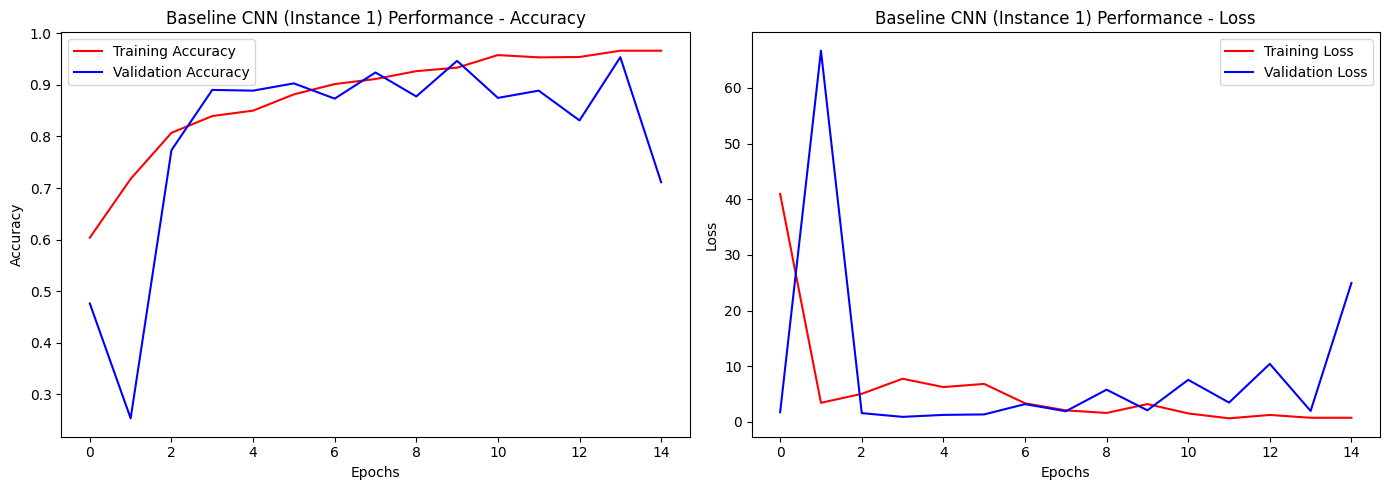


--- Baseline CNN Performance on Validation Set ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Accuracy: 0.7113
Precision: 0.7190
Recall: 0.6622
F1-score: 0.6467

Baseline CNN model saved to 'saved_models/baseline_cnn_model.keras'


In [36]:

# 1. Build the model using our reusable function
baseline_model = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=6,
    name="baseline_cnn"
)
baseline_model.summary()

# 2. Train the model
print("\n--- Training Baseline CNN (Instance 1) ---")
baseline_history = baseline_model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    verbose=1
)

# 3. Evaluate the model using our reusable functions
# Plot training history
plot_training_history(baseline_history, "Baseline CNN (Instance 1) Performance")

# Calculate and print metrics
print("\n--- Baseline CNN Performance on Validation Set ---")
# First, get the true labels from the validation dataset
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
# Then, get the model's predictions
y_val_pred_baseline = baseline_model.predict(validation_dataset)
# Now, use our reusable function
baseline_metrics = calculate_metrics(y_val_true, y_val_pred_baseline)

for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")


# 4. Save the trained model using the new .keras format
# This is required by the assignment
baseline_model.save('saved_models/baseline_cnn_model.keras')
print("\nBaseline CNN model saved to 'saved_models/baseline_cnn_model.keras'")

**Observations for Baseline CNN (Instance 1):**

* **Performance:** The baseline model achieved a validation accuracy of **71.13%** and an F1-score of **0.6467**. This is a considerable improvement over the SVM model, establishing a strong new baseline.
* **Overfitting:** The learning curves clearly show signs of overfitting. There is a large divergence between the training and validation accuracy/loss, indicating the model is not generalizing well.
* **Next Steps:** Our goal with the optimized models will be to reduce this overfitting and improve the validation accuracy.

### 4.4. Optimized Neural Networks (Instances 2-5)

#### 4.4.1. Optimized CNN (Instance 2) - Adding Dropout and Regularization

**Description:** For our first optimized model, we will use our `build_cnn_model` function to add two regularization techniques aimed at reducing the overfitting we saw in the baseline model:
1.  **Dropout:** A layer that randomly "turns off" neurons during training to prevent them from co-adapting too much.
2.  **L2 Regularization:** A penalty added to the loss function that discourages large weights, promoting a simpler model.
We will also introduce an **EarlyStopping** callback to monitor the validation loss and stop the training automatically when the model is no longer improving.

Model: "optimized_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Optimized CNN (Instance 2) ---
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - categorical_accuracy: 0.5147 - loss: 95.1682 - val_categorical_accuracy: 0.8366 - val_loss: 3.2555
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - categorical_accuracy: 0.8619 - loss: 3.1126 - val_categorical_accuracy: 0.7394 - val_loss: 3.4899
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - categorical_accuracy: 0.8886 - loss: 2.8794 - val_categorical_accuracy: 0.8535 - val_loss: 2.8191
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - categorical_accuracy: 0.9369 - loss: 2.3978 - val_categorical_accuracy: 0.7901 - val_loss: 2.9087
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - categorical_accuracy: 0.9156 - loss: 2.2878 - val_categorical_accuracy: 0.8845 - val_loss: 2.3641
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - categorical_accuracy: 0.9577 - loss: 1.9991 - val_categorical_accuracy: 0.9042 - val_loss: 2.1997
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━

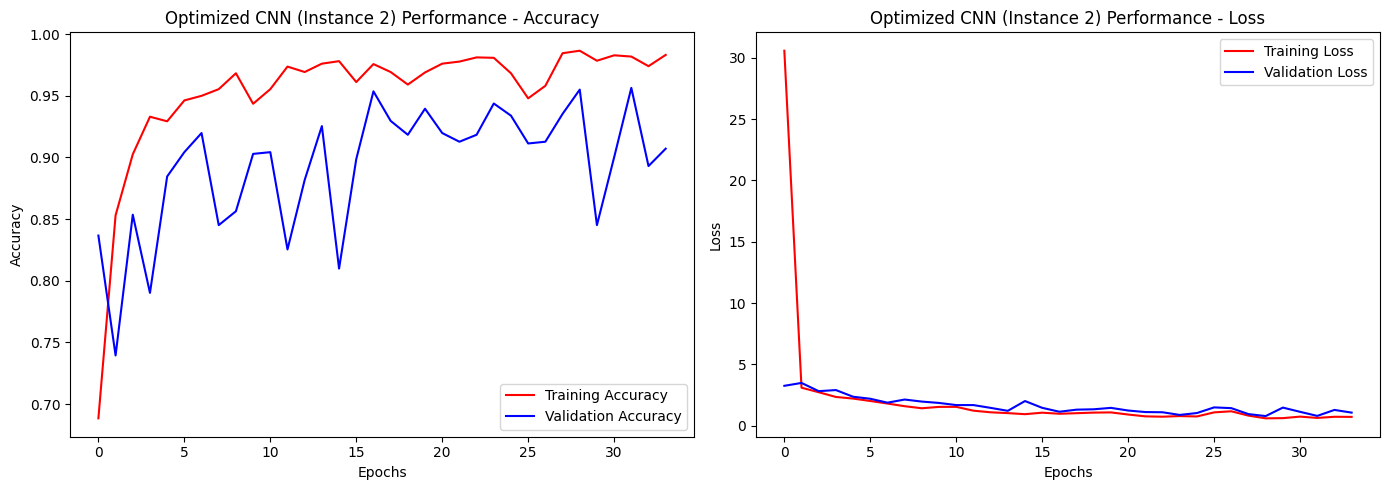


--- Optimized CNN (Instance 2) Performance on Validation Set ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Accuracy: 0.9549
Precision: 0.8967
Recall: 0.8504
F1-score: 0.8608

Optimized CNN model 1 saved to 'saved_models/' directory.


In [39]:
# We call our reusable function with new arguments for optimization
optimized_model_1 = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=6,
    optimizer_name='adam',       # Using a different optimizer
    learning_rate=0.001,
    dropout_rate=0.5,            # Adding a 50% dropout layer
    regularizer=regularizers.l2(0.01), # Adding L2 regularization
    name="optimized_cnn_1"
)
optimized_model_1.summary()

# 2. Define the EarlyStopping callback
# This will stop training if the validation loss doesn't improve for 5 straight epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 3. Train the model
print("\n--- Training Optimized CNN (Instance 2) ---")
optimized_history_1 = optimized_model_1.fit(
    train_dataset,
    epochs=50, # We can set a higher max epochs, EarlyStopping will handle the rest
    validation_data=validation_dataset,
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)

# 4. Evaluate and save the model
plot_training_history(optimized_history_1, "Optimized CNN (Instance 2) Performance")

print("\n--- Optimized CNN (Instance 2) Performance on Validation Set ---")
y_val_pred_opt1 = optimized_model_1.predict(validation_dataset)
opt1_metrics = calculate_metrics(y_val_true, y_val_pred_opt1)

for metric, value in opt1_metrics.items():
    print(f"{metric}: {value:.4f}")

optimized_model_1.save('saved_models/optimized_cnn_model_1.keras')
print("\nOptimized CNN model 1 saved to 'saved_models/' directory.")

**Observations for Optimized CNN (Instance 2):**

* **Techniques Used:** This model introduced an `Adam` optimizer, a `Dropout` rate of 0.5, `L2 regularization`, and an `EarlyStopping` callback.
* **Performance:** The optimizations resulted in a significant performance increase, with validation accuracy jumping from 71.1% to **95.5%** and the F1-score increasing from 64.7% to **86.1%**.
* **Overfitting:** The learning curves show that the gap between training and validation metrics has narrowed considerably, indicating that Dropout and L2 Regularization were very effective at reducing overfitting.

#### 4.4.2. Optimized CNN (Instance 3) - New Optimization Mix

**Description:** For this instance, we will test a different combination of hyperparameters while keeping the model architecture the same as the baseline. We will switch the optimizer to `RMSprop`, use `L1` regularization instead of L2, and reduce the `Dropout` rate to 0.2. This allows us to observe how a different set of optimization techniques impacts the model's performance and its ability to generalize.

Model: "optimized_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Optimized CNN (Instance 3) ---
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - categorical_accuracy: 0.4765 - loss: 305.1416 - val_categorical_accuracy: 0.4324 - val_loss: 38.3398
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - categorical_accuracy: 0.4789 - loss: 41.1971 - val_categorical_accuracy: 0.5408 - val_loss: 37.2072
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - categorical_accuracy: 0.4986 - loss: 40.3627 - val_categorical_accuracy: 0.4451 - val_loss: 38.2282
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - categorical_accuracy: 0.5438 - loss: 38.4318 - val_categorical_accuracy: 0.6254 - val_loss: 37.5790
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - categorical_accuracy: 0.5565 - loss: 39.5684 - val_categorical_accuracy: 0.5155 - val_loss: 38.8234
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - categorical_accuracy: 0.5665 - loss: 40.2907 - val_categorical_accuracy: 0.4761 - val_loss: 41.0702
Epoch 7/50
93/93 ━━━━━━━

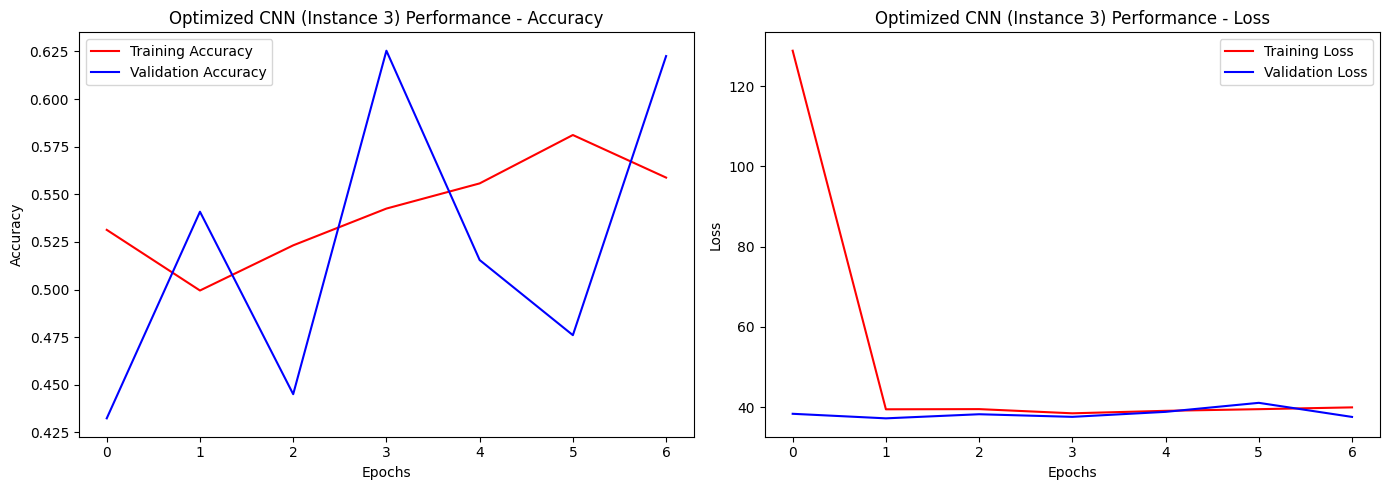


--- Optimized CNN (Instance 3) Performance on Validation Set ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Accuracy: 0.5408
Precision: 0.4333
Recall: 0.4502
F1-score: 0.4202

Optimized CNN model 2 saved to 'saved_models/' directory.


/Users/testsolutions/Documents/school/year3/term1/intro-to-ml-summative/rinda-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# 1. Build the new Optimized Model
optimized_model_2 = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=6,
    optimizer_name='rmsprop',           
    learning_rate=0.001,
    dropout_rate=0.2,                   
    regularizer=regularizers.l1(0.01),  
    name="optimized_cnn_2"
)
optimized_model_2.summary()

# 2. Define the EarlyStopping callback (reused from before)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 3. Train the model
print("\n--- Training Optimized CNN (Instance 3) ---")
optimized_history_2 = optimized_model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate and save the model
plot_training_history(optimized_history_2, "Optimized CNN (Instance 3) Performance")

print("\n--- Optimized CNN (Instance 3) Performance on Validation Set ---")
y_val_pred_opt2 = optimized_model_2.predict(validation_dataset)
opt2_metrics = calculate_metrics(y_val_true, y_val_pred_opt2)

for metric, value in opt2_metrics.items():
    print(f"{metric}: {value:.4f}")

optimized_model_2.save('saved_models/optimized_cnn_model_2.keras')
print("\nOptimized CNN model 2 saved to 'saved_models/' directory.")

**Observations for Optimized CNN (Instance 3):**

* **Techniques Used:** This instance used the `RMSprop` optimizer, a `Dropout` rate of 0.2, and a strong `L1` regularization penalty. The architecture remained the same.
* **Performance:** This combination of hyperparameters resulted in very poor performance, with an accuracy of only **54.1%**.
* **Analysis:** The learning curves were highly unstable, indicating the model failed to learn effectively. This was likely caused by the strong `L1(0.01)` regularization, which may have overly penalized the model and prevented it from converging. This experiment demonstrates that not all optimization techniques, or combinations thereof, will lead to an improvement.

#### 4.4.3. Optimized CNN (Instance 4) - SGD Optimizer

**Description:** In this experiment, we test another combination of hyperparameters. We will use the `SGD` optimizer, which is another common choice for training neural networks. We will use a moderate `Dropout` rate of 0.4 and remove all L1/L2 regularization to see how this simpler regularization scheme performs.

Model: "optimized_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Optimized CNN (Instance 4) ---
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - categorical_accuracy: 0.2461 - loss: 88654.4219 - val_categorical_accuracy: 0.2141 - val_loss: 1.7419
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - categorical_accuracy: 0.2106 - loss: 1.7471 - val_categorical_accuracy: 0.2141 - val_loss: 1.6931
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - categorical_accuracy: 0.2488 - loss: 1.7176 - val_categorical_accuracy: 0.3141 - val_loss: 1.6620
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - categorical_accuracy: 0.2821 - loss: 1.6974 - val_categorical_accuracy: 0.3141 - val_loss: 1.6502
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - categorical_accuracy: 0.2820 - loss: 1.6902 - val_categorical_accuracy: 0.3141 - val_loss: 1.6436
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - categorical_accuracy: 0.2821 - loss: 1.6854 - val_categorical_accuracy: 0.3141 - val_loss: 1.6409
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━

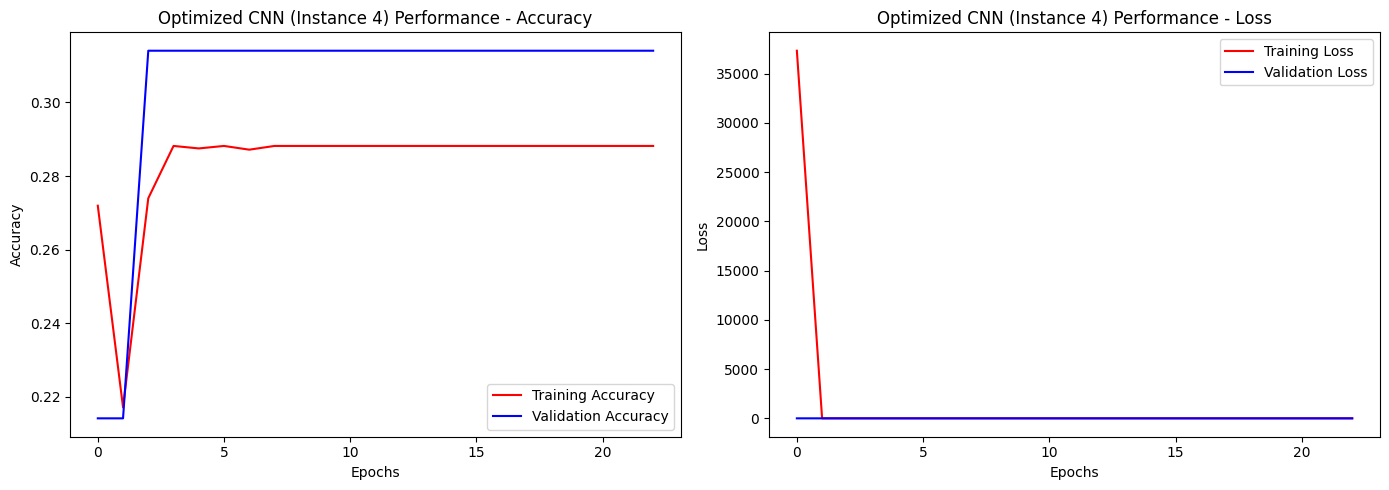


--- Optimized CNN (Instance 4) Performance on Validation Set ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Accuracy: 0.3141
Precision: 0.0523
Recall: 0.1667
F1-score: 0.0797

Optimized CNN model 3 saved to 'saved_models/' directory.


/Users/testsolutions/Documents/school/year3/term1/intro-to-ml-summative/rinda-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# 1. Build the new Optimized Model
optimized_model_3 = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=6,
    optimizer_name='sgd',            
    learning_rate=0.001,
    dropout_rate=0.4,                
    regularizer=None,               
    name="optimized_cnn_3"
)
optimized_model_3.summary()

# 2. Define the EarlyStopping callback (reused from before)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 3. Train the model
print("\n--- Training Optimized CNN (Instance 4) ---")
optimized_history_3 = optimized_model_3.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate and save the model
plot_training_history(optimized_history_3, "Optimized CNN (Instance 4) Performance")

print("\n--- Optimized CNN (Instance 4) Performance on Validation Set ---")
y_val_pred_opt3 = optimized_model_3.predict(validation_dataset)
opt3_metrics = calculate_metrics(y_val_true, y_val_pred_opt3)

for metric, value in opt3_metrics.items():
    print(f"{metric}: {value:.4f}")

optimized_model_3.save('saved_models/optimized_cnn_model_3.keras')
print("\nOptimized CNN model 3 saved to 'saved_models/' directory.")

**Observations for Optimized CNN (Instance 4):**

* **Techniques Used:** This instance used the `SGD` optimizer, a `Dropout` rate of 0.4, and no L1/L2 regularization.
* **Performance:** This combination performed very poorly, achieving only **31.4%** accuracy and an **8.0%** F1-score.
* **Analysis:** The learning curves show that the model's learning stalled almost immediately. This suggests that the standard `SGD` optimizer with a learning rate of 0.001 was not suitable for this problem and was unable to converge to a good solution.

#### 4.4.4. Optimized CNN (Instance 5) - Fine-Tuning Learning Rate

**Description:** For our final optimized instance, we will build upon our most successful model (Instance 2). We will use the same successful techniques (`Adam` optimizer, `Dropout`, `L2 Regularization`). However, we will reduce the learning rate from `0.001` to `0.0001`. This fine-tuning can sometimes lead to better convergence and a more accurate final model.

Model: "optimized_cnn_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Optimized CNN (Instance 5) ---
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - categorical_accuracy: 0.2918 - loss: 44.3923 - val_categorical_accuracy: 0.3563 - val_loss: 3.2075
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - categorical_accuracy: 0.3471 - loss: 3.1798 - val_categorical_accuracy: 0.3845 - val_loss: 3.0034
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - categorical_accuracy: 0.3881 - loss: 3.0574 - val_categorical_accuracy: 0.4183 - val_loss: 2.9814
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - categorical_accuracy: 0.3416 - loss: 2.9515 - val_categorical_accuracy: 0.3817 - val_loss: 2.7147
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - categorical_accuracy: 0.3862 - loss: 2.7889 - val_categorical_accuracy: 0.3901 - val_loss: 2.6246
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - categorical_accuracy: 0.4173 - loss: 2.6607 - val_categorical_accuracy: 0.6014 - val_loss: 2.4801
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━

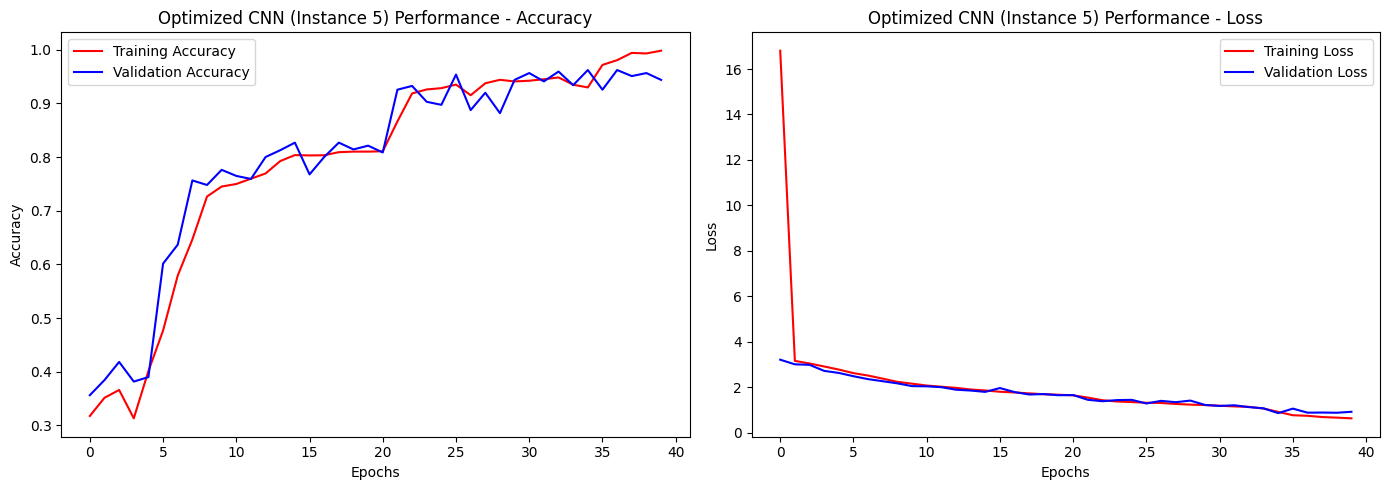


--- Optimized CNN (Instance 5) Performance on Validation Set ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Accuracy: 0.9620
Precision: 0.9714
Recall: 0.8368
F1-score: 0.8538

Optimized CNN model 4 saved to 'saved_models/' directory.


In [43]:
# 1. Build the Final Optimized Model
optimized_model_4 = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=6,
    optimizer_name='adam',           # <-- Using our successful optimizer
    learning_rate=0.0001,            # <-- CHANGE: Fine-tuning with a smaller LR
    dropout_rate=0.5,                # <-- Using our successful dropout rate
    regularizer=regularizers.l2(0.01), # <-- Using our successful regularizer
    name="optimized_cnn_4"
)
optimized_model_4.summary()

# 2. Define the EarlyStopping callback (reused from before)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 3. Train the model
print("\n--- Training Optimized CNN (Instance 5) ---")
optimized_history_4 = optimized_model_4.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate and save the model
plot_training_history(optimized_history_4, "Optimized CNN (Instance 5) Performance")

print("\n--- Optimized CNN (Instance 5) Performance on Validation Set ---")
y_val_pred_opt4 = optimized_model_4.predict(validation_dataset)
opt4_metrics = calculate_metrics(y_val_true, y_val_pred_opt4)

for metric, value in opt4_metrics.items():
    print(f"{metric}: {value:.4f}")

optimized_model_4.save('saved_models/optimized_cnn_model_4.keras')
print("\nOptimized CNN model 4 saved to 'saved_models/' directory.")

**Observations for Optimized CNN (Instance 5):**

* **Techniques Used:** This instance was a fine-tuning of our best model so far. It used the `Adam` optimizer with a smaller learning rate of `0.0001`, along with a `Dropout` rate of 0.5 and `L2 regularization`.
* **Performance:** This model achieved the highest validation accuracy of all experiments at **96.2%**. The learning curves show an excellent fit with very little overfitting.
* **Analysis:** Reducing the learning rate allowed the model to converge to a more optimal and stable solution, resulting in a slight but meaningful increase in accuracy over Instance 2. This demonstrates the value of fine-tuning hyperparameters.